In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [2]:
warnings.filterwarnings('ignore')
DATA_DIR = 'D:/Sem7/Capstone 2/teaLeafBD/teaLeafBD'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = "cuda" if tf.config.list_physical_devices('GPU') else "cpu"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None
)

Found 5276 files belonging to 7 classes.
Using 4221 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None
)

Found 5276 files belonging to 7 classes.
Using 1055 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

Found 7 classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']


In [6]:
def apply_preprocessing(image):
    image_np = image.numpy().astype(np.uint8)
    img_blur = cv2.GaussianBlur(image_np, (5, 5), 0)
    img_lab = cv2.cvtColor(img_blur, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge([cl, a, b])
    img_final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return img_final.astype(np.float32)


In [7]:
@tf.function
def tf_apply_preprocessing(image, label):
    [image,] = tf.py_function(apply_preprocessing, [image], [tf.float32])
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image, label

In [8]:
train_ds = train_ds.map(tf_apply_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(tf_apply_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)


train_ds = train_ds.batch(BATCH_SIZE) # <--- FIX 2: Batch AFTER mapping
val_ds = val_ds.batch(BATCH_SIZE) # <--- FIX 2

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

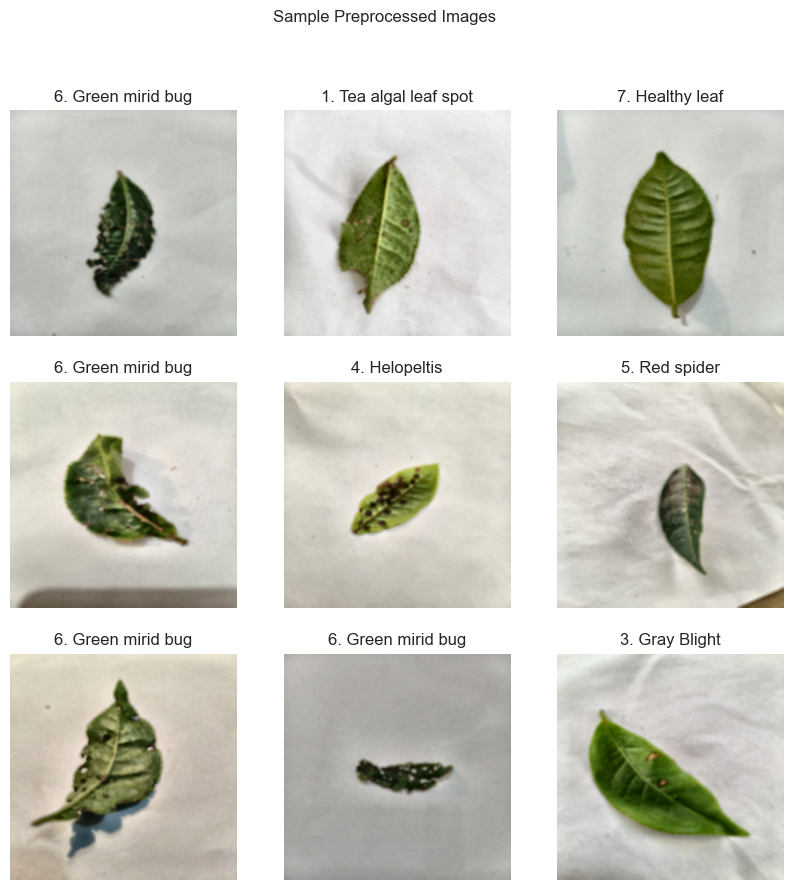

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1).as_numpy_iterator():
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.suptitle("Sample Preprocessed Images")
plt.show()

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

In [11]:
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

In [12]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply augmentation
x = layers.Rescaling(1./255)(x) # Normalize pixel values
x = base_model(x, training=False)  # Run the base model (in inference mode)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularization
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Classifier head

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',  # Use this loss for integer labels
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("Training complete.")
model.save('tea_leaf_disease_tf.keras')


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.2021 - loss: 1.9060 - val_accuracy: 0.2559 - val_loss: 1.8602
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2279 - loss: 1.8860 - val_accuracy: 0.2559 - val_loss: 1.8600
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.2270 - loss: 1.8850 - val_accuracy: 0.2559 - val_loss: 1.8606
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2201 - loss: 1.8865 - val_accuracy: 0.2559 - val_loss: 1.8600
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2281 - loss: 1.8854 - val_accuracy: 0.2559 - val_loss: 1.8599
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.2225 - loss: 1.8840 - val_accuracy: 0.2559 - val_loss: 1.8600
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.2312 - loss: 1.8838 - val_accuracy: 0.2559 - val_loss: 1.8599
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2265 - loss: 1.8848 - val_accu

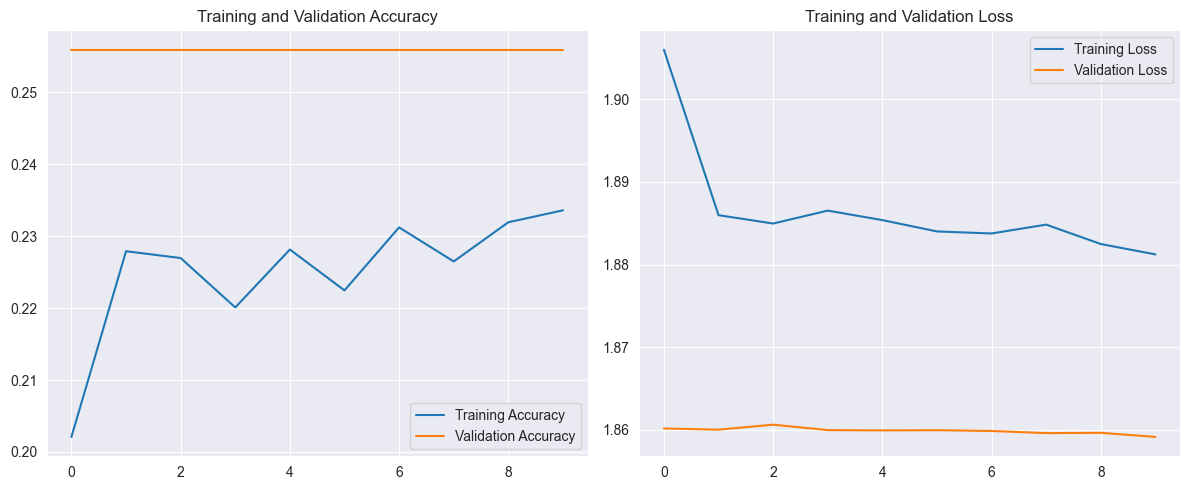

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [15]:
print("Generating predictions on validation data...")
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))


Generating predictions on validation data...
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 944ms/step

--- Classification Report ---
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.00      0.00      0.00        76
       2. Brown Blight       0.00      0.00      0.00        96
        3. Gray Blight       0.00      0.00      0.00       192
         4. Helopeltis       0.00      0.00      0.00       130
         5. Red spider       0.00      0.00      0.00        97
    6. Green mirid bug       0.26      1.00      0.41       270
       7. Healthy leaf       0.00      0.00      0.00       194

              accuracy                           0.26      1055
             macro avg       0.04      0.14      0.06      1055
          weighted avg       0.07      0.26      0.10      1055




--- Confusion Matrix ---


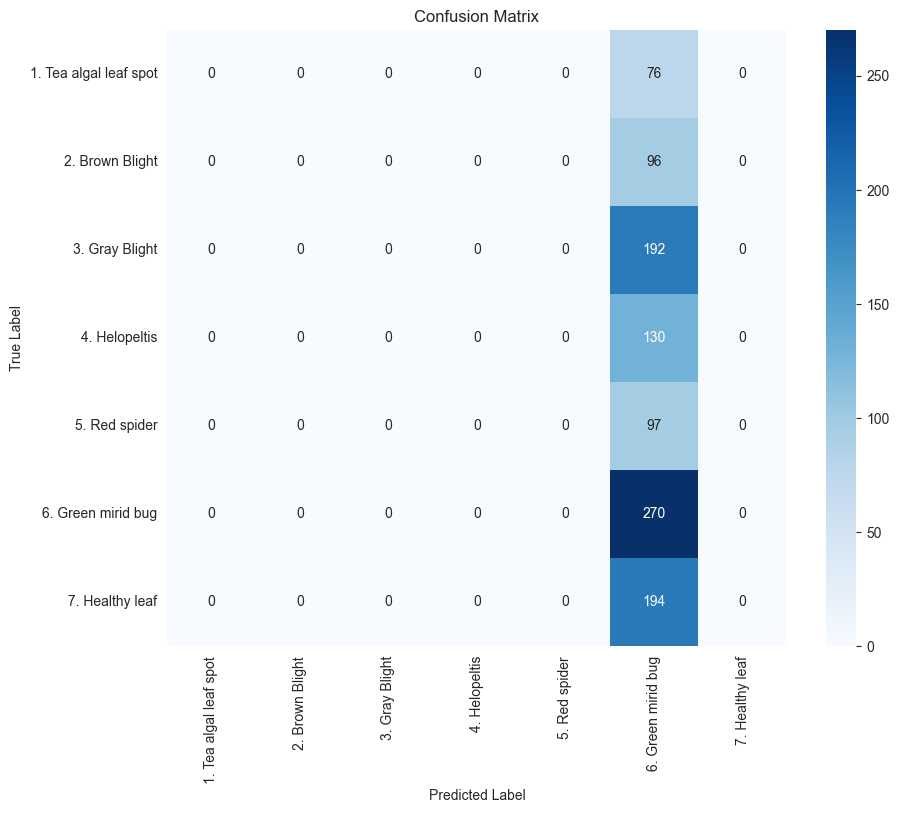

In [16]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()